# Programming assignment 5: spotting cars using convolutional neural networks<a
href="#Programming-assignment-5:-spotting-cars-using-convolutional-neural-networks"
class="anchor-link">¶</a>

In this assignment, we will see a few different approaches to building
image classifiers using convolutional neural networks.

We have a small image dataset and our task is to train a CNN that can
find images that contain cars. CNNs are data-hungry in general and we
won't get a fantastic accuracy using this dataset, so as an alternative
we'll explore the opportunity to "piggyback" on a pre-trained CNN model
for another image classification task.

Purposes of this assignment:

-   practicing the use of the Keras library for neural network
    development;
-   getting some practical experience of working with image data and
    CNNs;
-   investigating overfitting in CNNs;
-   learning how to improve your CNN using data augmentation and
    transfer learning tricks.

Work in a group up of two or three people. You should submit a single
Jupyter notebook including your code and comments as Markdown boxes.

Before submitting, please make sure that:

-   the names of all members of the group are listed at the beginning of
    the notebook;
-   all intermediate steps, results, and your conclusions are described
    carefully;
-   the code can be executed **in one go without crashing or errors**.
    If you use a notebook, please select *Restart & Run All* in the
    Kernel menu before you submit;

Submit the files at the submission page in Canvas.

# Preliminaries<a href="#Preliminaries" class="anchor-link">¶</a>

-   Repeat the lectures (or at least the notebooks) about neural network
    basics and convolutional neural networks.
-   Make sure that Keras is installed. You can install by
    entering`conda install tensorflow` if using Anaconda. (The most
    recent version of Keras is bundled with the TensorFlow library.)
-   If you are installing via pip/pip3 rather than Anaconda, you will
    need to install `h5py` as well, if you'd like to be able to save
    your trained models.
-   Install the image processing library Pillow, which is needed by the
    Keras functions that load the images. (`conda install pillow` or
    \`pip3 install Pillow)

# Introduction: Loading images from a directory<a href="#Introduction:-Loading-images-from-a-directory"
class="anchor-link">¶</a>

In this section, we'll see how we can a set of images stored in a
directory. Your work here does not need to be included in the report.

First download the package containing the images (a5_images.zip) and
unpack it. These images have been extracted from a dataset included in
the [PASCAL Visual Object Classes Challenge
2010](http://host.robots.ox.ac.uk/pascal/VOC/voc2010/) (VOC2010).

The structure of the directory is

-   a5_images
    -   train
        -   car \[800 images\]
        -   other \[800 images\]
    -   validation
        -   car \[288 images\]
        -   other \[288 images\]

so as you can see, the images have already been split into a training
and a validation set, and each subset contains a separate directory for
each of the two classes (`car` and `other`). The class `other` contains
images of various objects.

Keras includes a function `load_img` to load a single image, but we'll
use a more practical approach for this assignment.

We first declare an `ImageDataGenerator`. This is an object that defines
how images should be converted into NumPy data. In our case, we add a
parameter `rescale`; this means that the color values range from 0 to 1
instead of 0 to 255. (This transformation is similar to a scaler in
scikit-learn and has a similar purpose.)

In \[ \]:

    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    data_gen = ImageDataGenerator(rescale=1.0/255)

Now, let's read the images in the training set. By calling
`flow_from_director`, we apply the `ImageDataGenerator` to transform the
images stored in a directory. This will return a generator object that
loads images, transforms them, and returns them in batches of a given
size.

The parameters used here are:

-   the location of the training images;
-   `target_size` is for the size of the images: in our case, we'll
    resize them so that they are all 64x64 pixels;
-   `batch_size` refers to the batch size we'll use when training;
-   `class_mode='binary'` means that we'll treat the learning problem as
    a binary classification problem;
-   `classes` is provided to make sure that `other` is coded as 0 and
    `car` as 1;
-   `seed` is an arbitrary integer that initializes the random number
    generator for reproducibility;
-   `shuffle` because we'd like the images to appear in a random order
    when training.

If you have a severe performance problem, you can resize the images to
some size smaller than 64x64. This is likely to give you a slightly
lower classification accuracy. (Conversely, if you have a high-end
machine, you may consider increasing the image size.

In \[ \]:

    imgdir = 'a5_images' # or wherever you put them...
    img_size = 64
    batch_size = 32

    train_generator = data_gen.flow_from_directory(
            imgdir + '/train',
            target_size=(img_size, img_size),
            batch_size=batch_size,
            class_mode='binary',
            classes=['other', 'car'],
            seed=12345,
            shuffle=True)

We'll take a look at a few images. We first read one batch from the
generator. This will return a part of the training data: some images,
and the corresponding labels (0 for `other`, 1 for `car`).

In \[ \]:

    Xbatch, Ybatch = train_generator.next()

What is the form of the images in the batch? We take a look at the NumPy
object that was returned. It is a four-dimensional NumPy array
(formally, a four-dimensional *tensor*).

The dimensions are

-   32, because there are 32 images in the batch
-   64, for the height of each image
-   64, for the width of each image
-   3, because for each pixel we store the red, green, and blue value (a
    value between 0 and 1)

In \[ \]:

    Xbatch.shape

We'll take a look at the first instance. First, let's check whether this
is a car or not. In my case, the label is 0 for the first instance,
meaning that this is not a car. This doesn't have to be the case for
you, because the images appear in a random order (`shuffle=True`).

In \[ \]:

    Ybatch[4]

Draw the image using `plt.imshow`. (Assuming you have imported
`matplotlib.pyplot` as `plt`.) As usual when plotting, you'll need to
call `plt.show()` or `plt.savefig()`, or use an interactive notebook, to
see something.

Hopefully, you can confirm from the image whether this is a car or not
(and this should agree with `Ybatch[0]`). It might be a bit hard to see,
because we resized the image to 64x64.

In \[ \]:

    from matplotlib import pyplot as plt

In \[ \]:

    plt.imshow(Xbatch[4]);

# Part 1: Training a convolutional neural network<a href="#Part-1:-Training-a-convolutional-neural-network"
class="anchor-link">¶</a>

Write a function `make_convnet` that builds a convolutional neural
network.

The input shape should be `(img_size, img_size, 3)`, where `img_size` is
the image size we defined above (such as 64), and 3 is for the red,
green, and blue "channels" of the image. If you make use of the code we
saw during the lecture, please note that this is a binary classification
problem, so it's probably good to change the output layer and use
another loss function.

Also remember to select a suitable optimizer.

Before you can train the CNN, you need to make a second data generator
for the generation of validation images. You should again use
`data_gen.flow_from_directory`, but use the validation directory instead
of the training directory.

Now we have everything that we need to train the CNN. Call `fit` to
train the model.

In most cases, training will be fairly time-consuming. The exact amount
needed will depend on your machine, how you constructed your CNN, and
how many epochs you let it train. Typically, training will take a few
minutes.

Optionally, call `your_cnn.save_weights(some_file_name)` after training.
This will save your weights to a file; you can recover them later using
`your_cnn.load_weights(the_same_file_name)`, so that you can run your
CNN several times without having to re-train every time.

**Hint**: Depending on how you build your CNN, you will see different
accuracies. The dataset is balanced, so a majority-class dummy baseline
would have an accuracy of 0.5. Let's hope you can get a better result
than that. The validation set is a bit small because we don't have that
much data, so you will probably see some fluctuation in the accuracy
values.

Plot the training and validation loss for each epoch. Also plot the
training and validation accuracies in another plot.

If you need to run the model on a dataset that you access via a
generator, you can use `evaluate`. The loss function and the accuracy
will be computed. (As you can see, these values are the same as you got
in the last epoch when training.)

# Part 2: Data augmentation<a href="#Part-2:-Data-augmentation" class="anchor-link">¶</a>

Most likely, unless you applied early stopping very aggressively, you
saw some overfitting in your solution.

One approach to reducing the risk of overfitting to the training set is
to apply *data augmentation*. This means that we create additional
training instances by applying different types of modifications to the
existing training images.

Take a look at the documentation of `ImageDataGenerator`. Several of the
optional parameters enable different types of data augmentation, such as
rotation, mirroring, and changing the colors.

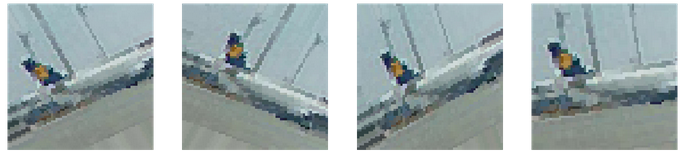

Make a new `ImageDataGenerator` that applies data augmentation to the
training images.

Make a new training data generator that uses the new
`ImageDataGenerator`, instead of the generator `data_gen` we originally
used, and retrain your model. (**Note**: The generator for reading the
validation data should not use data augumentation.)

Do you see an improvement on the validation set?

**Hint**: If you play around with different types of data augmentation
you will notice that there's a tradeoff between underfitting and
overfitting. Typically, if you tune your augmentation carefully you will
see a small improvement, but this will of course depend on how you built
your CNN. Also, keep in mind that our validation set is tiny, so we see
quite a bit of fluctuation in our evaluations. So even if the data
augmentation has actually improved your classifier, it might be hard to
discern the effect.

Again, plot the losses and accuracies. Do you see any change?

# Interlude: Applying a pre-trained convolutional neural network<a
href="#Interlude:-Applying-a-pre-trained-convolutional-neural-network"
class="anchor-link">¶</a>

One of the most famous image databases used in computer vision is called
[ImageNet](https://www.image-net.org/). It contains a very large number
of categories and an even larger number of example images for each
category. This is one of the standard benchmarks in the field.

Several CNNs that have been trained on ImageNet have been released to
the public, and Keras includes several of them. In this exercise, we'll
use the model called VGG-16, which was developed by a group at the
university of Oxford.
[Here](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) is a
description of VGG-16.

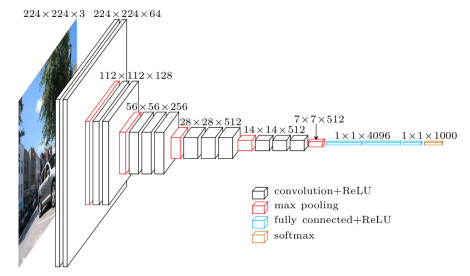

We use the built-in function in Keras to build the VGG-16 model and load
the weights. Here, `weights='imagenet'` means that we use the
pre-trained weights, and `include_top=True` that we use the full
classification model.

The first time you execute this code, the VGG-16 model will be
downloaded. (It will then be stored on your disk for future use.)

In \[ \]:

    from tensorflow.keras import applications
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    from tensorflow.keras.applications.vgg16 import decode_predictions, preprocess_input

    vggmodel = applications.VGG16(weights='imagenet', include_top=True)

To demonstrate the VGG-16 model as a classifier, we will now classify an
example image.

Carry out the following steps:

-   Select any image, for instance one from your training or validation
    data. Take a look at the image so that you see what it depicts.

-   Load the image using
    `load_img(the_file_name, target_size=(224,224))`. The 224x224 target
    size is required because this is the standard input size of the
    VGG-16 model when we use it as a classifier. This will return an
    `Image` object.

-   Convert the image into a 3-dimensional NumPy array using
    `img_to_array`.

-   Process the image using the Keras function `preprocess_input`. This
    function returns a new NumPy array. This step carries out some
    preprocessing of the image necessary for VGG-16. (This is different
    from dividing by 255 as we did previously.)

-   Finally, reshape the image array into a four-dimensional array.

    `your_image = your_image.reshape(1, 224, 224, 3)`

The reason for reshaping is that the `predict` function in Keras
operates on "batches" of images. Even if we are classifying just a
single image, we need to put it into an array.

Predict the class probabilities for this image, using
`vggmodel.predict`. This will result in a 1 x 1000 matrix. There are
1000 columns because the VGG-16 classifier uses 1000 ImageNet classes.

Apply the function `decode_prediction` to the output of the previous
step. This will convert the probability matrix into human-readable
ImageNet class labels. Does the prediction make sense?

# Part 3: Using VGG-16 as a feature extractor<a href="#Part-3:-Using-VGG-16-as-a-feature-extractor"
class="anchor-link">¶</a>

Let's return to the problem of finding images of cars.

Since we just have 1,600 training images, the CNN we trained earlier
wasn't fantastically successful. We'll now take a different approach,
inspired by the paper by [Razavian et al.
(2014)](http://openaccess.thecvf.com/content_cvpr_workshops_2014/W15/papers/Razavian_CNN_Features_Off-the-Shelf_2014_CVPR_paper.pdf):
we'll use the VGG-16 model as a feature extractor: we'll apply the
convolutional part of the VGG-16 model to our images, and use this
output as the input of our own classifier. This solution is an example
of **transfer learning**, which means that we leverage the knowledge
stored in a pre-trained model and apply it to our specific task.

To get started, we load the VGG-16 model once more. Please note that the
parameters are a bit different this time:

-   `include_top=False` because we won't use the highest layers in the
    ImageNet classifier. Instead, we'll train our own classifier.
-   We specify an `input_shape` that overrides the 224x224 size that is
    the default size used by VGG-16. For the purpose of comparing to our
    previous results, we'll use the same size as in our first CNN
    classifier.

In \[ \]:

    feature_extractor = applications.VGG16(include_top=False, weights='imagenet',
                                           input_shape=(img_size, img_size, 3))

Before reading the images, we need to create a new `ImageDataGenerator`
that applies `preprocess_input` (the preprocessing required for VGG-16)
to the images that it processes.

In \[ \]:

    vgg_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

Now, write a function `create_vgg16_features` that carries out the
following steps:

-   First, make a generator that reads a given directory (either the
    train or the validation directory). You should use `vgg_data_gen`,
    so that the preprocessing is done correctly. \[**Hint**: for reasons
    that will become clearer a bit later, if you set shuffle=False in
    the generator, you will make your life easier later on.\]

-   Second, apply the VGG-16 model to the generator
    (`feature_extractor.predict(...)`). This will return a
    four-dimensional NumPy array.

-   Third, save this NumPy array into a file.

    with open(SOME_FILE_NAME, 'wb') as f:

          np.save(f, cnn_features)

    Make sure that you don't use the same file name for the training
    part and the validation part. The `'wb'` option means that we are
    writing the data into a binary format, not a text format.

Call this function twice, once for the training part and once for the
validation part. This process should take a few minutes, depending on
the performance of your machine.

Finally, write a function `train_on_cnnfeatures` that reads the two
files that you created, trains a classifier on the training set, and
evaluates on the validation set. To read the files, you can write
something like this:

    with open(SOME_FILE_NAME, 'rb') as f:
        the_data = np.load(f)

Here, `'rb'` means that we are reading in a binary format.

You can use Keras or scikit-learn to train this classifier. But

-   If you use Keras, your first layer needs to be a `Flatten` layer, to
    convert the outputs from the last VGG-16 pooling layer into straight
    vectors.
-   If you use scikit-learn, you need to `reshape` the data
    appropriately, so that it becomes a two-dimensional NumPy matrix.

To keep things simple, the following helper function may be used to
create the output labels, assuming that the dataset has a size of `n`.
This function assumes that all the `other` instances come before the
`car` instances. (This is the reason we set `shuffle=False` in the
generator above.)

In \[ \]:

    def get_labels(n):
        return np.array([0]*(n//2) + [1]*(n//2))

What is your accuracy this time? If the accuracy is different from when
you trained your previous CNN, what do you think is the reason for the
difference?

**Hint**: If you have solved this task correctly, you are likely to see
an accuracy that is significantly higher than when you trained your
standalone CNN previously.

# Part 4: Visualizing the learned features<a href="#Part-4:-Visualizing-the-learned-features"
class="anchor-link">¶</a>

The first convolutional layer represents the most low-level patterns
that the model looks for in images. We will now visualize these features
in the VGG-16 model. (You can also repeat the exercise using your own
original model, but because we have so little data, the features in this
model may look less like interpretable patterns.)

We get the weights in this convolutional layer. This is a
four-dimensional NumPy tensor: width x height x colors x number of
convolutions.

In \[ \]:

    first_layer_weights = vggmodel.get_weights()[0]
    first_layer_weights.shape

We create a utility function that will help us visualize the patterns
extracted by the first convolutional layer.

This function takes three inputs: the layer's weight tensor (from the
step above), a number referring to which convolutional filter we are
considering (0-63), and finally a boolean (`True/False`) value that says
whether we want to see the positive or the negative part of this filter.
(That is, if `positive=True`, we see the patterns which enable this
"feature"; if it is `False`, we see the patterns that disable it.)

In \[ \]:

    def kernel_image(weights, i, positive):
        
        # extract the convolutional kernel at position i
        k = weights[:,:,:,i].copy()
        if not positive:
            k = -k
        
        # clip the values: if we're looking for positive
        # values, just keep the positive part; vice versa
        # for the negative values.
        k *= k > 0

        # rescale the colors, to make the images less dark
        m = k.max()
        if m > 1e-3:
            k /= m 

        return k

Finally, visualize some of the patterns used by the first convolutional
layer. It can be useful to show these images in pairs, so that for each
convolutional filter you see the positive and negative pattern.